# Rookie of the Year Award Prediction Pipeline

## Setup and Data Loading

In [120]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
awards_data = pd.read_csv("../../data/initial_data/awards_players.csv")
players_teams = pd.read_csv("../../data/initial_data/players_teams.csv")
teams_data = pd.read_csv("../../data/initial_data/teams.csv")
players_info = pd.read_csv("../../data/initial_data/players_clean.csv")

In [121]:
# ==========================================
# HELPER FUNCTIONS
# ==========================================

def identify_rookies(current_season_players_df, historical_players_df):
    """
    Identify rookies in the current season by comparing with historical data.
    
    Args:
        current_season_players_df (pd.DataFrame): DataFrame containing player data for the current season.
        historical_players_df (pd.DataFrame): DataFrame containing player data for all previous seasons.
        
    Returns:
        set: A set of playerIDs who are rookies (present in current but not in historical).
    """
    current_ids = set(current_season_players_df['playerID'].unique())
    historical_ids = set(historical_players_df['playerID'].unique())
    
    return current_ids - historical_ids


## Generate Rookie Data with True Previous Year Stats

In [122]:
# Identify rookies (first year a player appears in players_teams)
rookies = players_teams.sort_values('year').groupby('playerID').first().reset_index()
rookies = rookies[['playerID', 'year', 'tmID']].rename(columns={'year': 'rookie_year', 'tmID': 'rookie_team'})

print(f"Total rookies identified: {len(rookies)}")
print(f"Rookie years: {sorted(rookies['rookie_year'].unique())}")

# For each rookie, we need:
# 1. Their team's performance in the PREVIOUS year (year N-1)
# 2. Their teammates' stats from the PREVIOUS year (year N-1)
# 3. Their physical attributes

rookie_features = []

for _, rookie in rookies.iterrows():
    rookie_year = rookie['rookie_year']
    rookie_team = rookie['rookie_team']
    player_id = rookie['playerID']
    
    # Skip year 1 rookies (no previous year data available)
    if rookie_year <= 1:
        continue
    
    prev_year = rookie_year - 1
    
    # Get team performance from previous year
    team_prev = teams_data[(teams_data['tmID'] == rookie_team) & (teams_data['year'] == prev_year)]
    
    if len(team_prev) == 0:
        # Team didn't exist in previous year, skip this rookie
        continue
    
    team_wins = team_prev['won'].values[0]
    team_losses = team_prev['lost'].values[0]
    team_rank = team_prev['rank'].values[0] if 'rank' in team_prev.columns else np.nan
    
    # Get teammates from previous year (players who played on this team in prev_year)
    teammates_prev = players_teams[(players_teams['tmID'] == rookie_team) & 
                                   (players_teams['year'] == prev_year)]
    
    if len(teammates_prev) == 0:
        # No teammate data, skip
        continue
    
    # Calculate teammate aggregate stats from previous year
    # Use per-minute stats to normalize for playing time
    teammates_prev['points_per_min'] = teammates_prev['points'] / teammates_prev['minutes'].replace(0, 1)
    teammates_prev['rebounds_per_min'] = teammates_prev['rebounds'] / teammates_prev['minutes'].replace(0, 1)
    teammates_prev['assists_per_min'] = teammates_prev['assists'] / teammates_prev['minutes'].replace(0, 1)
    teammates_prev['total_contribution'] = teammates_prev['points'] + teammates_prev['rebounds'] + teammates_prev['assists']
    
    # Aggregate teammate stats
    num_teammates = len(teammates_prev)
    avg_teammate_points = teammates_prev['points'].mean()
    avg_teammate_rebounds = teammates_prev['rebounds'].mean()
    avg_teammate_assists = teammates_prev['assists'].mean()
    avg_teammate_minutes = teammates_prev['minutes'].mean()
    avg_teammate_per_min = teammates_prev['points_per_min'].mean()
    max_teammate_points = teammates_prev['points'].max()
    max_teammate_total = teammates_prev['total_contribution'].max()
    avg_teammate_total = teammates_prev['total_contribution'].mean()
    std_teammate_total = teammates_prev['total_contribution'].std()
    
    # Top 3 players' average contribution
    top3_total = teammates_prev.nlargest(3, 'total_contribution')['total_contribution'].mean()
    
    # Team weighted average per-minute performance
    total_team_minutes = teammates_prev['minutes'].sum()
    if total_team_minutes > 0:
        team_weighted_per_min = (teammates_prev['points_per_min'] * teammates_prev['minutes']).sum() / total_team_minutes
    else:
        team_weighted_per_min = 0
    
    rookie_features.append({
        'playerID': player_id,
        'year': rookie_year,  # The rookie's debut year
        'tmID': rookie_team,
        # Team stats from previous year (N-1)
        'team_wins_prev_year': team_wins,
        'team_losses_prev_year': team_losses,
        'team_rank_prev_year': team_rank,
        # Teammate stats from previous year (N-1)
        'num_teammates_prev_year': num_teammates,
        'avg_teammate_points_prev': avg_teammate_points,
        'avg_teammate_rebounds_prev': avg_teammate_rebounds,
        'avg_teammate_assists_prev': avg_teammate_assists,
        'avg_teammate_minutes_prev': avg_teammate_minutes,
        'avg_teammate_per_min_prev': avg_teammate_per_min,
        'max_teammate_points_prev': max_teammate_points,
        'max_teammate_total_prev': max_teammate_total,
        'avg_teammate_total_prev': avg_teammate_total,
        'std_teammate_total_prev': std_teammate_total if not pd.isna(std_teammate_total) else 0,
        'top3_avg_total_prev': top3_total,
        'team_weighted_per_min_prev': team_weighted_per_min
    })

# Create DataFrame
roty_data = pd.DataFrame(rookie_features)

# Add player physical attributes
roty_data = roty_data.merge(
    players_info[['bioID', 'pos', 'height', 'weight']],
    left_on='playerID',
    right_on='bioID',
    how='left'
)
roty_data.drop(columns=['bioID'], inplace=True)

# Add RotY winner field
target_award = 'Rookie of the Year'
roty_winners = awards_data[awards_data['award'] == target_award][['year', 'playerID']]

roty_data['RotY_winner'] = roty_data.apply(
    lambda row: 1 if ((roty_winners['year'] == row['year']) & 
                      (roty_winners['playerID'] == row['playerID'])).any() else 0,
    axis=1
)

print(f"\nData shape: {roty_data.shape}")
print(f"RotY winners in dataset: {roty_data['RotY_winner'].sum()}")
print(f"Years covered: {sorted(roty_data['year'].unique())}")

roty_data.to_csv("rookie_roty_data_fixed.csv", index=False)
print("\n✅ Saved to rookie_roty_data_fixed.csv")

Total rookies identified: 555
Rookie years: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Data shape: (343, 22)
RotY winners in dataset: 9
Years covered: [2, 3, 4, 5, 6, 7, 8, 9, 10]

✅ Saved to rookie_roty_data_fixed.csv


## Define Features and Prepare Data

In [123]:
# Define feature columns
feature_columns = [
    # Team previous year performance (year N-1, before rookie joined)
    'team_wins_prev_year',
    'team_losses_prev_year',
    'team_rank_prev_year',
    'team_weighted_per_min_prev',
    'num_teammates_prev_year',
    
    # Teammate stats from previous year (year N-1)
    # These are the rookie's teammates' performance in the year BEFORE the rookie joined
    'avg_teammate_points_prev',
    'avg_teammate_rebounds_prev',
    'avg_teammate_assists_prev',
    'avg_teammate_minutes_prev',
    'avg_teammate_per_min_prev',
    'max_teammate_points_prev',
    'max_teammate_total_prev',
    'avg_teammate_total_prev',
    'std_teammate_total_prev',
    'top3_avg_total_prev',
    
    # Player physical attributes
    'pos',
    'height',
    'weight'
]

# Prepare dataset for training
# Strategy: Predict year N RotY award using year N-1 data (teammate/team stats from previous year)
# The 'year' column = rookie's debut year = award year (year N)
# Features already contain year N-1 data (teammate stats from previous year, team performance from previous year)
data = pd.read_csv("rookie_roty_data_fixed.csv")

# The target is already correct - RotY_winner is 1 for winners in their debut year
# We just need to match this directly since features are already from previous year
data['Target'] = data['RotY_winner']

# Filter candidates (rookies typically play significant minutes)
# Note: Adjust thresholds as needed based on data
candidates = data.copy()

# Encode 'pos' column for models
candidates['pos'] = candidates['pos'].astype('category').cat.codes

print(f"Total candidates: {len(candidates)}")
print(f"Positive samples: {candidates['Target'].sum()}")

Total candidates: 343
Positive samples: 9


---
# Section 1: Single-Year Model Testing
Train on Award Years 2-9, Test on Award Year 10
(Note: Year N award predictions use year N-1 teammate/team data from features)

## 1.1 Logistic Regression

In [124]:
# Split data by award year (which equals the rookie's debut year)
# Train on award years 2-9, test on award year 10
# Note: For year N award, features already contain year N-1 data (teammates' previous year stats)
train_award_years = [2, 3, 4, 5, 6, 7, 8, 9]
test_award_year = 10

train_data = candidates[candidates['year'].isin(train_award_years)].copy()
test_data = candidates[candidates['year'] == test_award_year].copy()

X_train = train_data[feature_columns]
y_train = train_data['Target']
X_test = test_data[feature_columns]
y_test = test_data['Target']

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"Train positives: {y_train.sum()} | Test positives: {y_test.sum()}")

Train samples: 318 | Test samples: 25
Train positives: 8 | Test positives: 1


In [125]:
# Train Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
test_probs = model.predict_proba(X_test_scaled)[:, 1]

print("\n✅ Logistic Regression Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


✅ Logistic Regression Model trained!
Train accuracy: 0.887
Test accuracy: 0.840

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.20      1.00      0.33         1

    accuracy                           0.84        25
   macro avg       0.60      0.92      0.62        25
weighted avg       0.97      0.84      0.89        25



### Feature Importance (Logistic Regression)


Top 10 Most Important Features:
                   feature  coefficient
   std_teammate_total_prev    -2.512734
       team_rank_prev_year     1.605555
   max_teammate_total_prev     1.250311
                    height    -1.225162
team_weighted_per_min_prev     1.222264
       top3_avg_total_prev    -1.077422
   num_teammates_prev_year     1.053379
 avg_teammate_per_min_prev    -0.929586
                       pos    -0.666448
avg_teammate_rebounds_prev     0.622992


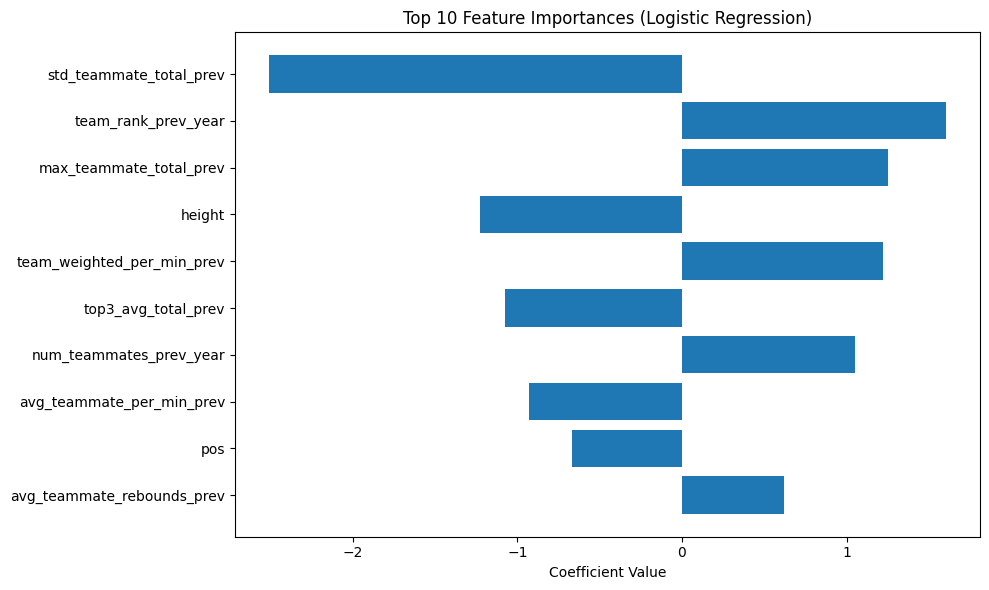

In [126]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (Logistic Regression)

In [127]:
# Show top predictions
test_data['lr_prob'] = test_probs
test_data_sorted = test_data.sort_values('lr_prob', ascending=False)

print(f"\nYear {test_award_year} RotY Predictions (Logistic Regression):")
print(f"Using year {test_award_year-1} teammate/team data to predict year {test_award_year} award")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['tmID']:<6}{row['lr_prob']:.4f}{'':6}{actual}")


Year 10 RotY Predictions (Logistic Regression):
Using year 9 teammate/team data to predict year 10 award
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     montgre01w          MIN   0.8675      
2     lehnish01w          ATL   0.8423      
3     mccouan01w          ATL   0.7667      ✅ WINNER
4     mccanra01w          MIN   0.6524      
5     montaan01w          MIN   0.6087      
6     holliqu01w          MIN   0.4092      
7     boddiwh01w          SAC   0.2645      
8     tolivkr01w          CHI   0.1264      
9     colemma01w          WAS   0.1214      
10    vaughki01w          NYL   0.1042      


## 1.2 XGBoost

In [128]:
# Train XGBoost
scale_pos_weight = len(y_train[y_train == 0]) / max(len(y_train[y_train == 1]), 1)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
test_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n✅ XGBoost Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred_xgb):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_xgb):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))


✅ XGBoost Model trained!
Train accuracy: 1.000
Test accuracy: 0.960

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       0.00      0.00      0.00         1

    accuracy                           0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Feature Importance (XGBoost)


Top 10 Most Important Features (XGBoost):
                   feature  importance
   std_teammate_total_prev    0.390369
   num_teammates_prev_year    0.167295
team_weighted_per_min_prev    0.069901
 avg_teammate_per_min_prev    0.064399
     team_losses_prev_year    0.050524
       top3_avg_total_prev    0.041297
                       pos    0.040950
       team_wins_prev_year    0.034819
                    weight    0.033799
                    height    0.027583


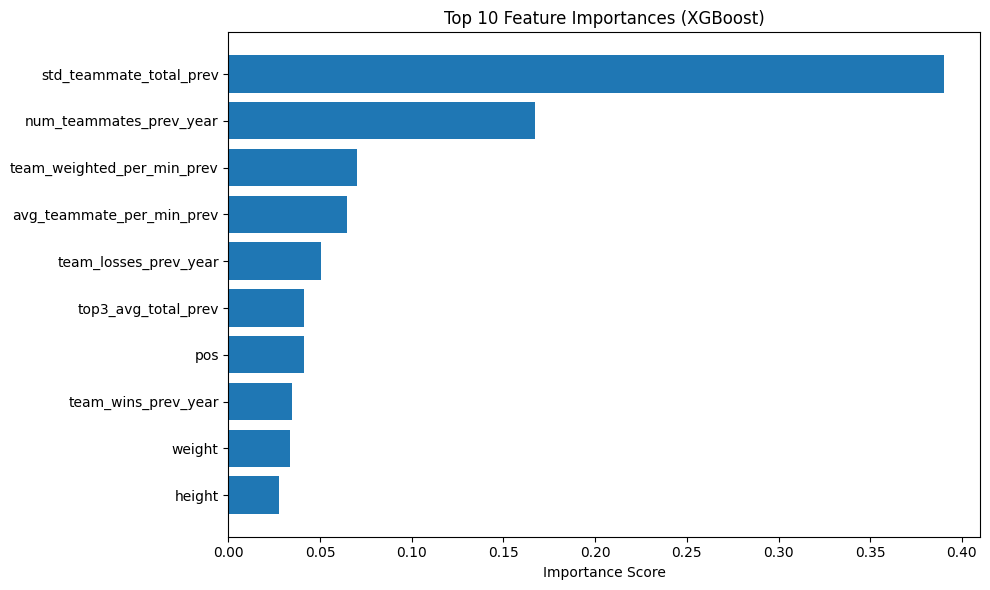

In [129]:
# Get feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_xgb.head(10)
plt.barh(top_features_xgb['feature'], top_features_xgb['importance'])
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (XGBoost)

In [130]:
# Show top predictions
test_data['xgb_prob'] = test_probs_xgb
test_data_sorted_xgb = test_data.sort_values('xgb_prob', ascending=False)

print(f"\nYear {test_award_year} RotY Predictions (XGBoost):")
print(f"Using year {test_award_year-1} teammate/team data to predict year {test_award_year} award")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted_xgb.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['tmID']:<6}{row['xgb_prob']:.4f}{'':6}{actual}")


Year 10 RotY Predictions (XGBoost):
Using year 9 teammate/team data to predict year 10 award
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     vaughki01w          NYL   0.0039      
2     colemma01w          WAS   0.0028      
3     bonnede01w          PHO   0.0027      
4     mccanra01w          MIN   0.0024      
5     tolivkr01w          CHI   0.0024      
6     mccouan01w          ATL   0.0022      ✅ WINNER
7     wisdoli01w          LAS   0.0021      
8     holliqu01w          MIN   0.0019      
9     montaan01w          MIN   0.0019      
10    januabr01w          IND   0.0019      


---
# Section 2: Multi-Year Evaluation (Leave-One-Out Cross-Validation)
Evaluate models across all available years

In [131]:
# Walk-Forward Cross-Validation Loop (Expand Window)
# Train on years [min_year, ..., T-1], Test on year T
# Note: In rookie_award.ipynb, 'year' is the award year (using prev year data implicitly)

award_years = sorted(candidates['year'].unique())
results = []
min_year = min(award_years)

# Start loop from the 3rd available year to have at least 2 years of training data
start_idx = 2 
if start_idx >= len(award_years):
    start_idx = 1 # Fallback

print(f"Running Walk-Forward Cross-Validation...")
print(f"{'Test Year':<10}{'Train Years':<15}{'LR Top1':<10}{'XGB Top1':<10}{'LR Rank':<10}{'XGB Rank':<10}{'Winner'}")
print("-" * 85)

for i in range(start_idx, len(award_years)):
    test_year = award_years[i]
    
    # Walk-Forward Split: Train on ALL years prior to test_year
    train_mask = candidates['year'] < test_year
    test_mask = candidates['year'] == test_year
    
    train_data_cv = candidates[train_mask].copy()
    test_data_cv = candidates[test_mask].copy()
    
    if len(test_data_cv) == 0 or len(train_data_cv) == 0:
        continue
        
    X_train_cv = train_data_cv[feature_columns]
    y_train_cv = train_data_cv['Target']
    X_test_cv = test_data_cv[feature_columns]
    y_test_cv = test_data_cv['Target']
    
    # --- Logistic Regression ---
    scaler_cv = StandardScaler()
    X_train_scaled_cv = scaler_cv.fit_transform(X_train_cv)
    X_test_scaled_cv = scaler_cv.transform(X_test_cv)
    
    lr_model_cv = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr_model_cv.fit(X_train_scaled_cv, y_train_cv)
    
    lr_prob_cv = lr_model_cv.predict_proba(X_test_scaled_cv)[:, 1]
    
    # --- XGBoost ---
    scale_pos_weight_cv = len(y_train_cv[y_train_cv == 0]) / max(len(y_train_cv[y_train_cv == 1]), 1)
    
    xgb_model_cv = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight_cv,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        verbosity=0
    )
    xgb_model_cv.fit(X_train_cv, y_train_cv)
    xgb_prob_cv = xgb_model_cv.predict_proba(X_test_cv)[:, 1]

    # --- Random Forest ---
    rf_model_cv = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model_cv.fit(X_train_cv, y_train_cv)
    rf_prob_cv = rf_model_cv.predict_proba(X_test_cv)[:, 1]
    
    # --- Metrics: Top K & Rank ---
    test_data_cv['lr_prob'] = lr_prob_cv
    test_data_cv['xgb_prob'] = xgb_prob_cv
    test_data_cv['rf_prob'] = rf_prob_cv
    
    # Sort by probability
    lr_sorted = test_data_cv.sort_values('lr_prob', ascending=False).reset_index(drop=True)
    xgb_sorted = test_data_cv.sort_values('xgb_prob', ascending=False).reset_index(drop=True)
    rf_sorted = test_data_cv.sort_values('rf_prob', ascending=False).reset_index(drop=True)
    
    actual_winner_row = test_data_cv[test_data_cv['Target'] == 1]
    
    lr_rank = np.nan
    xgb_rank = np.nan
    rf_rank = np.nan
    winner_id = "Unknown"
    
    if len(actual_winner_row) > 0:
        winner_id = actual_winner_row.iloc[0]['playerID']
        
        # Find Rank
        lr_rank_idx = lr_sorted[lr_sorted['playerID'] == winner_id].index
        xgb_rank_idx = xgb_sorted[xgb_sorted['playerID'] == winner_id].index
        rf_rank_idx = rf_sorted[rf_sorted['playerID'] == winner_id].index
        if len(lr_rank_idx) > 0: lr_rank = lr_rank_idx[0] + 1
        if len(xgb_rank_idx) > 0: xgb_rank = xgb_rank_idx[0] + 1
        if len(rf_rank_idx) > 0: rf_rank = rf_rank_idx[0] + 1
    
    # Check Top K
    lr_top1 = 1 if lr_rank == 1 else 0
    lr_top5 = 1 if lr_rank <= 5 else 0
    lr_top10 = 1 if lr_rank <= 10 else 0
    lr_top20 = 1 if lr_rank <= 20 else 0
    lr_top30 = 1 if lr_rank <= 30 else 0
    lr_top50 = 1 if lr_rank <= 50 else 0
    
    xgb_top1 = 1 if xgb_rank == 1 else 0
    xgb_top5 = 1 if xgb_rank <= 5 else 0
    xgb_top10 = 1 if xgb_rank <= 10 else 0
    xgb_top20 = 1 if xgb_rank <= 20 else 0
    xgb_top30 = 1 if xgb_rank <= 30 else 0
    xgb_top50 = 1 if xgb_rank <= 50 else 0

    rf_top1 = 1 if rf_rank == 1 else 0
    rf_top5 = 1 if rf_rank <= 5 else 0
    rf_top10 = 1 if rf_rank <= 10 else 0
    rf_top20 = 1 if rf_rank <= 20 else 0
    rf_top30 = 1 if rf_rank <= 30 else 0
    rf_top50 = 1 if rf_rank <= 50 else 0

    train_years_str = f"{min_year}-{test_year-1}"
    print(f"{test_year:<10}{train_years_str:<15}{lr_top1:<10}{xgb_top1:<10}{lr_rank:<10}{xgb_rank:<10}{winner_id}")
    
    results.append({
        'Test_Year': test_year,
        'LR_Rank': lr_rank,
        'XGB_Rank': xgb_rank,
        'RF_Rank': rf_rank,
        'LR_Top1': lr_top1, 'LR_Top5': lr_top5, 'LR_Top10': lr_top10,
        'LR_Top20': lr_top20, 'LR_Top30': lr_top30, 'LR_Top50': lr_top50,
        'XGB_Top1': xgb_top1, 'XGB_Top5': xgb_top5, 'XGB_Top10': xgb_top10, 'XGB_Top20': xgb_top20,
        'XGB_Top30': xgb_top30, 'XGB_Top50': xgb_top50,
        'RF_Top1': rf_top1, 'RF_Top5': rf_top5, 'RF_Top10': rf_top10, 'RF_Top20': rf_top20,
        'RF_Top30': rf_top30, 'RF_Top50': rf_top50
    })


Running Walk-Forward Cross-Validation...
Test Year Train Years    LR Top1   XGB Top1  LR Rank   XGB Rank  Winner
-------------------------------------------------------------------------------------
4         2-3            0         0         11        12        fordch01w
5         2-4            0         0         7         12        tauradi01w
6         2-5            0         0         3         3         johnste01w
7         2-6            0         0         11        2         augusse01w
8         2-7            0         0         2         2         pricear01w
9         2-8            0         0         4         8         parkeca01w
10        2-9            0         0         3         6         mccouan01w


## Summary of Multi-Year Results


===== Walk-Forward Validation Results =====
Metric                       | Logistic Reg | XGBoost | Random Forest
----------------------------------------------------------
Top-1 Accuracy               | 0.0%        | 0.0%        | 0.0%
Top-5 Accuracy               | 57.1%        | 42.9%          | 42.9%
Top-10 Accuracy              | 71.4%        | 71.4%        | 85.7%
Top-20 Accuracy              | 100.0%        | 100.0%        | 100.0%
Top-30 Accuracy              | 100.0%        | 100.0%        | 100.0%
Top-50 Accuracy              | 100.0%        | 100.0%        | 100.0%
Average Rank                 | 5.9          | 6.4          | 7.3
Rank Std Dev (Consistency)   | 3.8          | 4.4          | 5.3


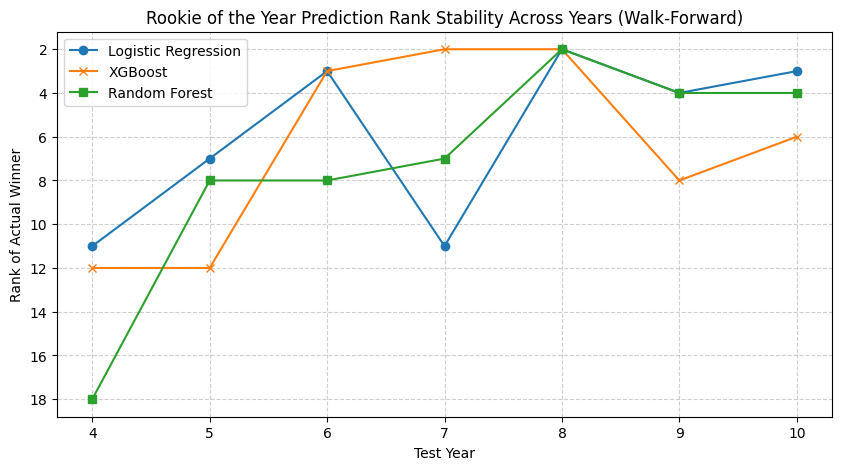

In [132]:
results_df = pd.DataFrame(results)

print("\n===== Walk-Forward Validation Results =====")
print("Metric                       | Logistic Reg | XGBoost | Random Forest")
print("----------------------------------------------------------")
print(f"Top-1 Accuracy               | {results_df['LR_Top1'].mean():.1%}        | {results_df['XGB_Top1'].mean():.1%}        | {results_df['RF_Top1'].mean():.1%}")
print(f"Top-5 Accuracy               | {results_df['LR_Top5'].mean():.1%}        | {results_df['XGB_Top5'].mean():.1%}          | {results_df['RF_Top5'].mean():.1%}")
print(f"Top-10 Accuracy              | {results_df['LR_Top10'].mean():.1%}        | {results_df['XGB_Top10'].mean():.1%}        | {results_df['RF_Top10'].mean():.1%}")
print(f"Top-20 Accuracy              | {results_df['LR_Top20'].mean():.1%}        | {results_df['XGB_Top20'].mean():.1%}        | {results_df['RF_Top20'].mean():.1%}")
print(f"Top-30 Accuracy              | {results_df['LR_Top30'].mean():.1%}        | {results_df['XGB_Top30'].mean():.1%}        | {results_df['RF_Top30'].mean():.1%}")
print(f"Top-50 Accuracy              | {results_df['LR_Top50'].mean():.1%}        | {results_df['XGB_Top50'].mean():.1%}        | {results_df['RF_Top50'].mean():.1%}")
print(f"Average Rank                 | {results_df['LR_Rank'].mean():.1f}          | {results_df['XGB_Rank'].mean():.1f}          | {results_df['RF_Rank'].mean():.1f}")
print(f"Rank Std Dev (Consistency)   | {results_df['LR_Rank'].std():.1f}          | {results_df['XGB_Rank'].std():.1f}          | {results_df['RF_Rank'].std():.1f}")

# Plot Rank Variation
plt.figure(figsize=(10, 5))
plt.plot(results_df['Test_Year'], results_df['LR_Rank'], marker='o', label='Logistic Regression')
plt.plot(results_df['Test_Year'], results_df['XGB_Rank'], marker='x', label='XGBoost')
plt.plot(results_df['Test_Year'], results_df['RF_Rank'], marker='s', label='Random Forest')
plt.gca().invert_yaxis()  # Rank 1 is at top
plt.title('Rookie of the Year Prediction Rank Stability Across Years (Walk-Forward)')
plt.ylabel('Rank of Actual Winner')
plt.xlabel('Test Year')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


---
# Section 3: Predict for New Year
Use this section to predict RotY for a future year using past data

## 3.1 Train Final Models on All Available Data

In [133]:
# Train on ALL available data
all_train_data = candidates.copy()
X_all = all_train_data[feature_columns]
y_all = all_train_data['Target']

# Train Logistic Regression
scaler_final = StandardScaler()
X_all_scaled = scaler_final.fit_transform(X_all)
model_final = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_final.fit(X_all_scaled, y_all)

# Train XGBoost
scale_pos_weight_final = len(y_all[y_all == 0]) / max(len(y_all[y_all == 1]), 1)
xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_final,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model_final.fit(X_all, y_all)

# Train Random Forest
rf_model_final = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_final.fit(X_all, y_all)

print("✅ Final models trained on all available data")

✅ Final models trained on all available data


## 3.2 Load New Year Data and Predict

In [134]:
# Load Year 11 Data
print("Loading Year 11 Data...")
year_11_players = pd.read_csv("../../data/test_data/players_teams.csv")
# We add a 'year' column if missing, assuming it is 11
if 'year' not in year_11_players.columns:
    year_11_players['year'] = 11

# Identify Rookies
# Historical data is 'players_teams' loaded at the start (Years 1-10)
rookie_ids_11 = identify_rookies(year_11_players, players_teams)
print(f"Identified {len(rookie_ids_11)} rookies for Year 11")

# Save Rookie List
year_11_rookies_df = year_11_players[year_11_players['playerID'].isin(rookie_ids_11)].copy()
year_11_rookies_df.to_csv("year_11_players_teams_test_rookies.csv", index=False)
print("Saved to year_11_players_teams_test_rookies.csv")


Loading Year 11 Data...
Identified 42 rookies for Year 11
Saved to year_11_players_teams_test_rookies.csv


In [135]:
# Construct Features for Year 11 Rookies (using Year 10 Stats)
print("Constructing features using Year 10 statistics...")

rookie_features_11 = []
prev_year = 10

# Pre-filter Year 10 data for performance
teams_prev = teams_data[teams_data['year'] == prev_year]
teammates_prev_all = players_teams[players_teams['year'] == prev_year].copy()

# Calculate per-minute stats for teammates once
teammates_prev_all['points_per_min'] = teammates_prev_all['points'] / teammates_prev_all['minutes'].replace(0, 1)
teammates_prev_all['total_contribution'] = teammates_prev_all['points'] + teammates_prev_all['rebounds'] + teammates_prev_all['assists']

for _, rookie in year_11_rookies_df.iterrows():
    player_id = rookie['playerID']
    rookie_team = rookie['tmID']
    
    # Team performance from Year 10
    team_stats = teams_prev[teams_prev['tmID'] == rookie_team]
    if len(team_stats) == 0:
        continue
        
    team_wins = team_stats['won'].values[0]
    team_losses = team_stats['lost'].values[0]
    team_rank = team_stats['rank'].values[0] if 'rank' in team_stats.columns else np.nan
    
    # Teammates from Year 10
    teammates = teammates_prev_all[teammates_prev_all['tmID'] == rookie_team]
    if len(teammates) == 0:
        continue
        
    # Aggregate Teammate Stats
    num_teammates = len(teammates)
    avg_teammate_points = teammates['points'].mean()
    avg_teammate_rebounds = teammates['rebounds'].mean()
    avg_teammate_assists = teammates['assists'].mean()
    avg_teammate_minutes = teammates['minutes'].mean()
    avg_teammate_per_min = teammates['points_per_min'].mean()
    max_teammate_points = teammates['points'].max()
    max_teammate_total = teammates['total_contribution'].max()
    avg_teammate_total = teammates['total_contribution'].mean()
    std_teammate_total = teammates['total_contribution'].std()
    top3_total = teammates.nlargest(3, 'total_contribution')['total_contribution'].mean()
    
    # Team weighted average
    total_team_minutes = teammates['minutes'].sum()
    if total_team_minutes > 0:
        team_weighted_per_min = (teammates['points_per_min'] * teammates['minutes']).sum() / total_team_minutes
    else:
        team_weighted_per_min = 0
        
    rookie_features_11.append({
        'playerID': player_id,
        'year': 11,
        'tmID': rookie_team,
        'team_wins_prev_year': team_wins,
        'team_losses_prev_year': team_losses,
        'team_rank_prev_year': team_rank,
        'num_teammates_prev_year': num_teammates,
        'avg_teammate_points_prev': avg_teammate_points,
        'avg_teammate_rebounds_prev': avg_teammate_rebounds,
        'avg_teammate_assists_prev': avg_teammate_assists,
        'avg_teammate_minutes_prev': avg_teammate_minutes,
        'avg_teammate_per_min_prev': avg_teammate_per_min,
        'max_teammate_points_prev': max_teammate_points,
        'max_teammate_total_prev': max_teammate_total,
        'avg_teammate_total_prev': avg_teammate_total,
        'std_teammate_total_prev': std_teammate_total if not pd.isna(std_teammate_total) else 0,
        'top3_avg_total_prev': top3_total,
        'team_weighted_per_min_prev': team_weighted_per_min
    })

year_11_data = pd.DataFrame(rookie_features_11)

# Join with Physical Attributes
year_11_data = year_11_data.merge(
    players_info[['bioID', 'pos', 'height', 'weight']],
    left_on='playerID',
    right_on='bioID',
    how='left'
)
if 'bioID' in year_11_data.columns:
    year_11_data.drop(columns=['bioID'], inplace=True)

# Encode Position
if 'pos' in year_11_data.columns:
    year_11_data['pos'] = year_11_data['pos'].astype('category').cat.codes

print(f"Prepared feature set for {len(year_11_data)} candidates.")


Constructing features using Year 10 statistics...
Prepared feature set for 37 candidates.


In [136]:
# Run Predictions
X_11 = year_11_data[feature_columns]
X_11_scaled = scaler_final.transform(X_11)

# Logistic Regression
lr_probs_11 = model_final.predict_proba(X_11_scaled)[:, 1]

# XGBoost
xgb_probs_11 = xgb_model_final.predict_proba(X_11)[:, 1]

year_11_data['LR_Prob'] = lr_probs_11
year_11_data['XGB_Prob'] = xgb_probs_11
year_11_data['RF_Prob'] = rf_model_final.predict_proba(X_11)[:, 1]

print("\n🏆 TOP YEAR 11 ROOKIE OF THE YEAR CANDIDATES 🏆")
print("="*60)

print("\n--- Logistic Regression Top 10 ---")
print(year_11_data[['playerID', 'tmID', 'LR_Prob']].sort_values('LR_Prob', ascending=False).head(10).to_string(index=False))

print("\n--- XGBoost Top 10 ---")
print(year_11_data[['playerID', 'tmID', 'XGB_Prob']].sort_values('XGB_Prob', ascending=False).head(10).to_string(index=False))

print("\n--- Random Forest Top 10 ---")
print(year_11_data[['playerID', 'tmID', 'RF_Prob']].sort_values('RF_Prob', ascending=False).head(10).to_string(index=False))



🏆 TOP YEAR 11 ROOKIE OF THE YEAR CANDIDATES 🏆

--- Logistic Regression Top 10 ---
  playerID tmID  LR_Prob
colsosy01w  NYL 0.970579
hightal01w  CON 0.922391
greenka01w  CON 0.885733
brelaje01w  NYL 0.827810
griffke01w  CON 0.812965
chestfe01w  NYL 0.807261
brelaje01w  CON 0.775706
mccrada01w  CON 0.771549
charlti01w  CON 0.727156
vandeco01w  CHI 0.717248

--- XGBoost Top 10 ---
  playerID tmID  XGB_Prob
brelaje01w  CON  0.460913
griffke01w  CON  0.204216
brelaje01w  NYL  0.188382
colsosy01w  NYL  0.171668
charlti01w  CON  0.113662
 oheaje01w  LAS  0.073482
lavenja01w  LAS  0.072389
mccrada01w  CON  0.071311
hightal01w  CON  0.056349
greenka01w  CON  0.032665

--- Random Forest Top 10 ---
  playerID tmID  RF_Prob
colsosy01w  NYL     0.11
hightal01w  CON     0.05
greenka01w  CON     0.04
brelaje01w  CON     0.04
brelaje01w  NYL     0.04
mccrada01w  CON     0.03
chestfe01w  NYL     0.03
montgal01w  NYL     0.02
charlti01w  CON     0.02
griffke01w  CON     0.02
